In [15]:
import re
import os
import utils as ut

from google.cloud import storage

def get_by_index(zscore,index_list):
    return pd.Series([zscore[0][iname] for iname in index_list])

def rmse(x,x_true):
    MSE = np.square(np.subtract(x.mean(),x_true)) 
    df_z = pd.DataFrame(np.sqrt(MSE))
    df_z.index = x.columns
    return df_z

def relative_error(x,x_true):
    MAE = np.subtract(x.mean(),x_true)
    df_z = pd.DataFrame(abs(100*MAE/x_true))
    df_z.index = x.columns
    return df_z

def download_blob(bucket_name, source_blob_name, destination_file_name):
    """
    Downloads a blob from the bucket to a local file.
    
    Args:
        bucket_name (str): Name of the GCP bucket
        source_blob_name (str): Path to the file in the bucket
        destination_file_name (str): Path where the file should be downloaded locally
    """
    storage_client = storage.Client()
    
    bucket = storage_client.bucket(bucket_name)
    
    blob = bucket.blob(source_blob_name)
    
    blob.download_to_filename(destination_file_name)
    
    print(
        f"Downloaded storage object {source_blob_name} from bucket {bucket_name} to {destination_file_name}"
    )

In [16]:
sites = [
  "CA_OBS",
  "DL55",
  "DL56",
  "DL57",
  "MD1",
  "OJP",
  "SCB",
  "SCC",
  "TVC50",
  "TVC51",
  "TVC52",
]

params = 'sample_matrix.csv'
model = 'results.csv'
target = "targets.csv"

arguments = []
for site in sites:
    local_destination = f"sites/{site}"
    os.makedirs(local_destination, exist_ok=True)
    arguments.append(("vb-tem", f"Sample_Runs/{site}/sample_matrix.csv", f"{local_destination}/sample_matrix.csv"))
    arguments.append(("vb-tem", f"Sample_Runs/{site}/results.csv", f"{local_destination}/results.csv"))
    arguments.append(("vb-tem", f"Sample_Runs/{site}/targets.csv", f"{local_destination}/targets.csv"))

In [17]:
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = []
    for args in arguments:
        futures.append(
            executor.submit(
                download_blob,
                *args,
            )
        )

    for future in futures:
        try:
            future.result()
        except Exception as e:
            print(e)

Downloaded storage object Sample_Runs/CA_OBS/targets.csv from bucket vb-tem to sites/CA_OBS/targets.csv
Downloaded storage object Sample_Runs/DL55/sample_matrix.csv from bucket vb-tem to sites/DL55/sample_matrix.csv
Downloaded storage object Sample_Runs/CA_OBS/sample_matrix.csv from bucket vb-tem to sites/CA_OBS/sample_matrix.csv
Downloaded storage object Sample_Runs/CA_OBS/results.csv from bucket vb-tem to sites/CA_OBS/results.csv
Downloaded storage object Sample_Runs/DL55/results.csv from bucket vb-tem to sites/DL55/results.csv
Downloaded storage object Sample_Runs/DL55/targets.csv from bucket vb-tem to sites/DL55/targets.csv
Downloaded storage object Sample_Runs/DL56/targets.csv from bucket vb-tem to sites/DL56/targets.csv
Downloaded storage object Sample_Runs/DL56/sample_matrix.csv from bucket vb-tem to sites/DL56/sample_matrix.csv
Downloaded storage object Sample_Runs/DL56/results.csv from bucket vb-tem to sites/DL56/results.csv
Downloaded storage object Sample_Runs/DL57/sample_ma

In [18]:
def create_custom_colorbar(error_type='rmse'):
    color_levels = [-1.0, -0.6, -0.2, 0.2, 0.6, 1.0]
    colors = ['darkblue', 'lightblue', '#f2f2f2', 'orange', 'red']
    cmap = LinearSegmentedColormap.from_list('custom_discrete', colors, N=len(color_levels) - 1)
    norm = BoundaryNorm(color_levels, cmap.N, clip=True)

    if error_type == 'rmse':
        cbar_label = 'RMSE score'
    elif error_type == 'diff':
        cbar_label = 'Normalized (Mean - Observed)'
    else:
        cbar_label = 'RE score'

    return cmap, norm, cbar_label

In [19]:
import matplotlib.image as mpimg
from matplotlib.cm import ScalarMappable

def apply_colorbar_to_image(image_path, output_path=None, error_type='diff', 
                           orientation='horizontal', figsize=None, 
                           colorbar_position='bottom'):
    cmap, norm, cbar_label = create_custom_colorbar(error_type)

    img = mpimg.imread(image_path)

    if figsize is None:
        height, width = img.shape[:2]
        aspect_ratio = width / height
        
        # Adjust figsize calculation to better match the image
        if orientation == 'vertical':
            fig_height = 10
            fig_width = fig_height * aspect_ratio
        else:  # horizontal
            fig_width = 12
            fig_height = fig_width / aspect_ratio
            
        figsize = (fig_width, fig_height)
    
    # Create figure with tighter layout
    fig = plt.figure(figsize=figsize)
    
    # Adjust the size and positioning of image and colorbar
    if colorbar_position == 'right':
        img_width = 0.85
        img_ax = plt.axes([0.05, 0.05, img_width, 0.9])
        cbar_ax = plt.axes([0.05 + img_width + 0.01, 0.25, 0.02, 0.5])
        orientation = 'vertical'
    elif colorbar_position == 'left':
        img_width = 0.85
        img_ax = plt.axes([0.15, 0.05, img_width, 0.9])
        cbar_ax = plt.axes([0.05, 0.25, 0.02, 0.5])
        orientation = 'vertical'
    elif colorbar_position == 'top':
        img_height = 0.85
        img_ax = plt.axes([0.05, 0.05, 0.9, img_height])
        cbar_ax = plt.axes([0.25, 0.05 + img_height + 0.01, 0.5, 0.02])
        orientation = 'horizontal'
    elif colorbar_position == 'bottom':
        img_height = 0.85
        img_ax = plt.axes([0.05, 0.15, 0.9, img_height])
        cbar_ax = plt.axes([0.25, 0.05, 0.5, 0.02])
        orientation = 'horizontal'

    img_ax.imshow(img)
    img_ax.axis('off')

    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    # Create a more compact colorbar
    colorbar = fig.colorbar(sm, cax=cbar_ax, orientation=orientation, 
                           ticks=[-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
    
    # Adjust the font size for better readability
    colorbar.ax.tick_params(labelsize=9)

    if orientation == 'vertical':
        colorbar.ax.set_ylabel(cbar_label, rotation=270, va="bottom", labelpad=15, fontsize=10)
    else:
        colorbar.ax.set_xlabel(cbar_label, fontsize=10)

    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        print(f"Image saved to {output_path}")

    return fig

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import seaborn as sns
import os
import re


def plot(path, params="sample_matrix.csv", model="results.csv", target="targets.csv"):
    df_param = pd.read_csv(os.path.join(path, params))
    df_model = pd.read_csv(os.path.join(path, model))
    target_df = pd.read_csv(os.path.join(path, target), skiprows=[0])
    df_model  = pd.concat([df_model, target_df], ignore_index=True)

    xparams_MD1, ymodel_MD1 =  ut.get_best_match(df_param,df_model)
    rmetric='r2rmse'
    nelem=10
    order=True
    y_sort=ymodel_MD1.sort_values(by=[rmetric],ascending=order).iloc[:nelem,:-6].copy()
    df2 = pd.concat([y_sort, df_model.iloc[-1:]], ignore_index=True)

    error='diff'
    # Define groups for separate normalization
    gpp_cols = [col for col in df_model.columns if 'GPP' in col]
    npp_cols = [col for col in df_model.columns if 'NPP' in col]
    c_leaf_cols = [col for col in df_model.columns if 'VEGC' in col and 'Leaf' in col]
    c_stem_cols = [col for col in df_model.columns if 'VEGC' in col and 'Stem' in col]
    c_root_cols = [col for col in df_model.columns if 'VEGC' in col and 'Root' in col]
    n_leaf_cols = [col for col in df_model.columns if 'VEGN' in col and 'Leaf' in col]
    n_stem_cols = [col for col in df_model.columns if 'VEGN' in col and 'Stem' in col]
    n_root_cols = [col for col in df_model.columns if 'VEGN' in col and 'Root' in col]
    n_soil = [col for col in df_model.columns if col in ['SHLWC', 'DEEPC', 'MINEC', 'AVLN']]

    n_size=len(df2.iloc[:,0])-1
    df_model_normalized = df2.copy() 

    df_model_normalized_gpp = df2[gpp_cols]/ max(df2[gpp_cols].max())

    df_model_normalized_npp = df2[npp_cols]/ max(df2[npp_cols].max())

    c_combined=c_leaf_cols+c_stem_cols+c_root_cols
    df_model_normalized_c_combined = df2[c_combined]/ max(df2[c_combined].max())

    n_combined=n_leaf_cols+n_stem_cols+n_root_cols
    df_model_normalized_n_combined = df2[n_combined]/ max(df2[n_combined].max())

    df_model_normalized_soil = df2[n_soil]/ max(df2[n_soil].max())

    if error=='re':
        rmse_gpp = relative_error(df_model_normalized_gpp.iloc[:n_size],df_model_normalized_gpp.iloc[n_size]) 
        rmse_npp = relative_error(df_model_normalized_npp.iloc[:n_size],df_model_normalized_npp.iloc[n_size]) 
        rmse_c = relative_error(df_model_normalized_c_combined.iloc[:n_size],df_model_normalized_c_combined.iloc[n_size]) 
        rmse_n = relative_error(df_model_normalized_n_combined.iloc[:n_size],df_model_normalized_n_combined.iloc[n_size]) 
        rmse_soil = relative_error(df_model_normalized_soil.iloc[:n_size],df_model_normalized_soil.iloc[n_size]) 
    elif error=='diff':
        rmse_gpp = (df_model_normalized_gpp.iloc[:n_size].mean()-df_model_normalized_gpp.iloc[n_size]).to_frame() 
        rmse_npp = (df_model_normalized_npp.iloc[:n_size].mean()-df_model_normalized_npp.iloc[n_size]).to_frame() 
        rmse_c = (df_model_normalized_c_combined.iloc[:n_size].mean()-df_model_normalized_c_combined.iloc[n_size]).to_frame() 
        rmse_n = (df_model_normalized_n_combined.iloc[:n_size].mean()-df_model_normalized_n_combined.iloc[n_size]).to_frame() 
        rmse_soil = (df_model_normalized_soil.iloc[:n_size].mean()-df_model_normalized_soil.iloc[n_size]).to_frame() 
    else:
        rmse_gpp = rmse(df_model_normalized_gpp.iloc[:n_size],df_model_normalized_gpp.iloc[n_size]) 
        rmse_npp = rmse(df_model_normalized_npp.iloc[:n_size],df_model_normalized_npp.iloc[n_size]) 
        rmse_c = rmse(df_model_normalized_c_combined.iloc[:n_size],df_model_normalized_c_combined.iloc[n_size]) 
        rmse_n = rmse(df_model_normalized_n_combined.iloc[:n_size],df_model_normalized_n_combined.iloc[n_size]) 
        rmse_soil = rmse(df_model_normalized_soil.iloc[:n_size],df_model_normalized_soil.iloc[n_size])

    #build the error matrix
    err_matrix_above = pd.DataFrame({
        'GPP': get_by_index(rmse_gpp, gpp_cols),
        'NPP': get_by_index(rmse_npp, npp_cols),
        '$C_{leaf}$': get_by_index(rmse_c, c_leaf_cols), 
        '$C_{stem}$': get_by_index(rmse_c, c_stem_cols), 
        '$C_{root}$': get_by_index(rmse_c, c_root_cols),
        '$N_{leaf}$': get_by_index(rmse_n, n_leaf_cols), 
        '$N_{stem}$': get_by_index(rmse_n, n_stem_cols), 
        '$N_{root}$': get_by_index(rmse_n, n_root_cols)
            })

    # Extract all pft numbers using regex
    pfts = set()

    for col in df_model.columns:
        match = re.search(r'pft[0-9]+', col)
        if match:
            pfts.add(match.group())

    # Turn into a sorted list
    pft_list = sorted(pfts)
    # print(pft_list)
    err_matrix_above.index=pft_list

    err_matrix_below = pd.DataFrame({
        'Soils': get_by_index(rmse_soil, n_soil)
            })

    err_matrix_below.index=n_soil

    cmap, norm, cbar_label = create_custom_colorbar(error)

    sns.set(font_scale=1.5) 

    fig_combined = plt.figure(figsize=(7, 8))
    gs = fig_combined.add_gridspec(2, 1, height_ratios=[9, 1])
    ax_combined1 = fig_combined.add_subplot(gs[0, 0])
    ax_combined2 = fig_combined.add_subplot(gs[1, 0])

    sns.heatmap(err_matrix_above.T, cmap=cmap, norm=norm, annot=True, fmt=".3f",
                cbar_kws={'label': cbar_label, "orientation": 'horizontal', 'pad': 0.15},
                cbar=False,
                annot_kws={"fontsize":12},
                ax=ax_combined1)
    ax_combined1.set_title("PFT Comparison")

    sns.heatmap(err_matrix_below.T, cmap=cmap, norm=norm, annot=True, fmt=".3f",
                cbar_kws={'label': cbar_label, "orientation": 'horizontal', 'pad': 0.35},
                cbar=False,
                annot_kws={"fontsize":12},
                ax=ax_combined2)
    ax_combined2.set_title("Soil Comparison")

    fig_combined.suptitle(path, fontsize=20, y=0.98, fontweight="bold")
    fig_combined.tight_layout()

    combined_path = os.path.join(path, f"{site}.png")
    fig_combined.savefig(combined_path, dpi=300, bbox_inches='tight')
    
    plt.close("all")
    
    return err_matrix_below, err_matrix_above

CA_OBS
DL55
DL56
DL57
MD1
OJP
SCB
SCC
TVC50
TVC51
Image data of dtype object cannot be converted to float
TVC52
Image data of dtype object cannot be converted to float


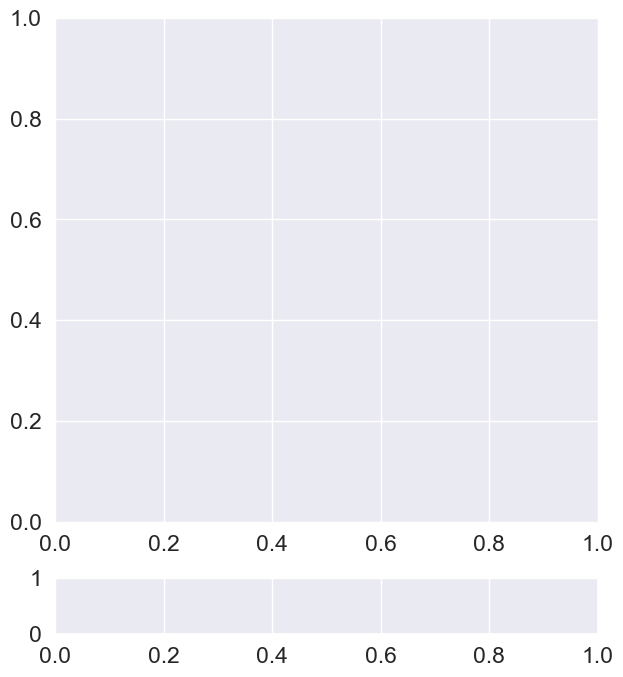

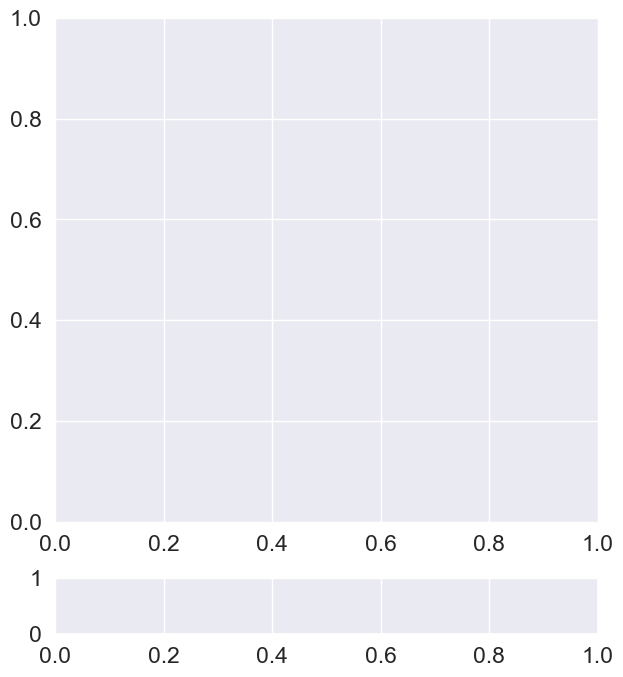

In [21]:
pft_comparison = []
soil_comparison = []
for site in sites:
    try:
        print(site)
        site_path = f"sites/{site}"
        soil_comp, pft_comp = plot(site_path)

        pft_comparison.append((site, pft_comp))
        soil_comparison.append((site, soil_comp))
    except Exception as e:
        print(e)

In [22]:
for s, u in pft_comparison:
    u.to_csv(f"sites/{s}/pft_comparison.csv")
    print(f"sites/{s}/pft_comparison.csv")

for s, l in soil_comparison:
    l.to_csv(f"sites/{s}/soil_comparison.csv")
    print(f"sites/{s}/soil_comparison.csv")

sites/CA_OBS/pft_comparison.csv
sites/DL55/pft_comparison.csv
sites/DL56/pft_comparison.csv
sites/DL57/pft_comparison.csv
sites/MD1/pft_comparison.csv
sites/OJP/pft_comparison.csv
sites/SCB/pft_comparison.csv
sites/SCC/pft_comparison.csv
sites/TVC50/pft_comparison.csv
sites/CA_OBS/soil_comparison.csv
sites/DL55/soil_comparison.csv
sites/DL56/soil_comparison.csv
sites/DL57/soil_comparison.csv
sites/MD1/soil_comparison.csv
sites/OJP/soil_comparison.csv
sites/SCB/soil_comparison.csv
sites/SCC/soil_comparison.csv
sites/TVC50/soil_comparison.csv


In [23]:
from PIL import Image
import os
import math

def merge_images_grid(image_paths, output_path, cols=None):
    """
    Merge multiple images into a grid-like layout for comparison.
    
    Args:
        image_paths (list): List of paths to the images to be merged
        output_path (str): Path where the merged image will be saved
        cols (int, optional): Number of columns in the grid. If None, will try to make a square grid.
    
    Returns:
        PIL.Image.Image: The merged image
    """
    if not image_paths:
        raise ValueError("No images provided")
    
    # Open all images and get their sizes
    images = [Image.open(path) for path in image_paths]
    
    # Determine grid dimensions
    num_images = len(images)
    if cols is None:
        cols = int(math.sqrt(num_images))
    rows = math.ceil(num_images / cols)
    
    # Find the maximum width and height of all images
    max_width = max(img.width for img in images)
    max_height = max(img.height for img in images)
    
    # Create a new blank image with the calculated dimensions
    merged_width = max_width * cols
    merged_height = max_height * rows
    merged_image = Image.new('RGB', (merged_width, merged_height), color='white')
    
    # Paste each image into the grid
    for idx, img in enumerate(images):
        row = idx // cols
        col = idx % cols
        x_offset = col * max_width
        y_offset = row * max_height
        
        # Center the image in its cell if smaller than max dimensions
        x_pos = x_offset + (max_width - img.width) // 2
        y_pos = y_offset + (max_height - img.height) // 2
        
        merged_image.paste(img, (x_pos, y_pos))
    
    # Save the merged image
    merged_image.save(output_path)
    
    return merged_image

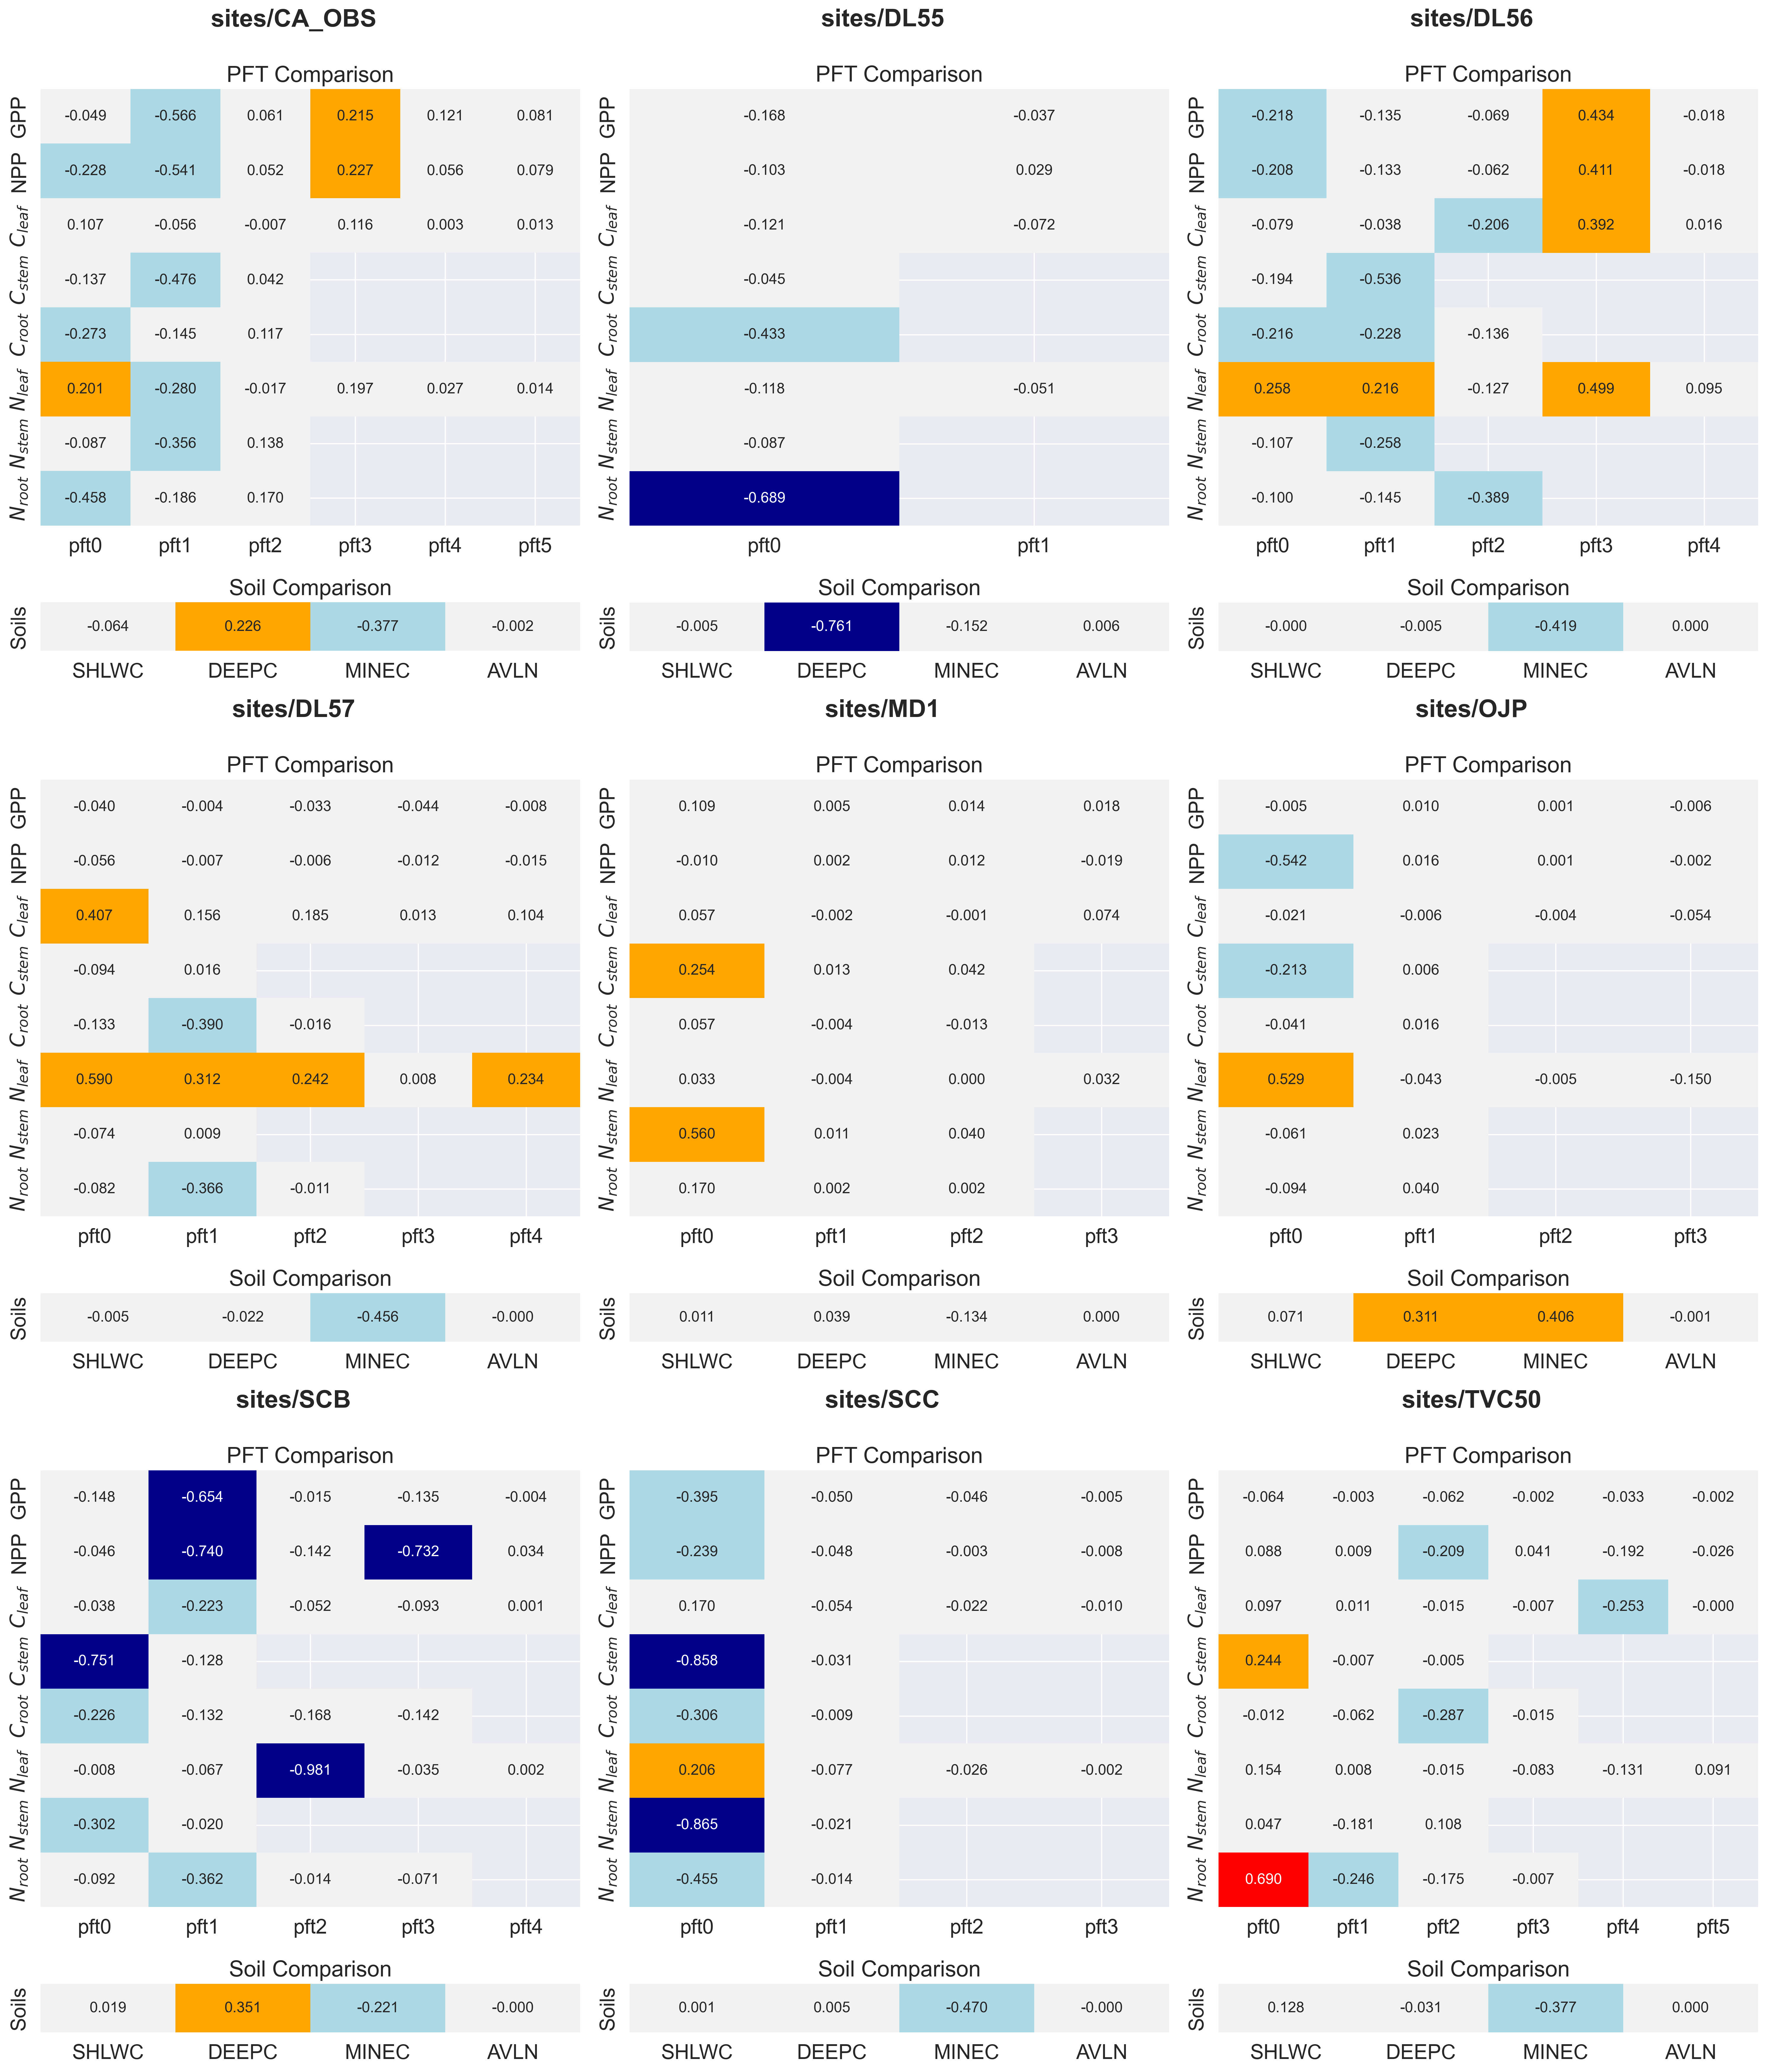

In [24]:
image_paths = []
for site in sites:
    image_paths.append(f"sites/{site}/{site}.png")

merge_images_grid(image_paths[:-2], "sites/comparison.png", cols=3)

/var/folders/vs/4q9hz82x2h13h0dbyl3s7b4r0000gq/T/ipykernel_27017/287810462.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Image saved to sites/image_with_colorbar.png


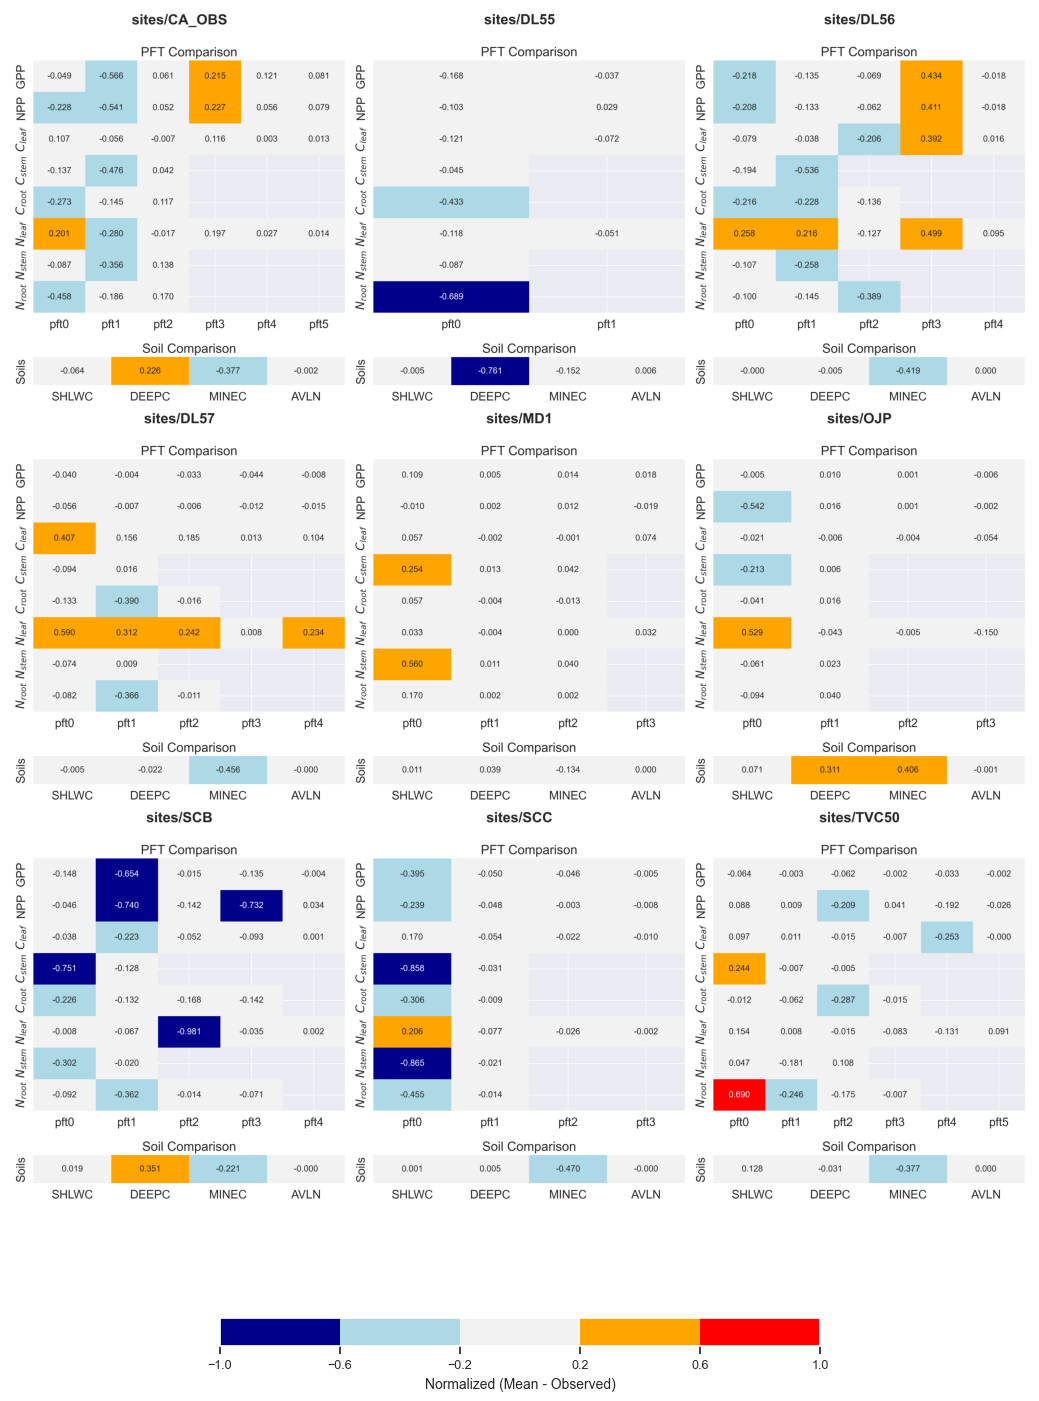

In [25]:
fig = apply_colorbar_to_image(
    image_path="sites/comparison.png",
    output_path="sites/image_with_colorbar.png",
    error_type='diff',  # Use 'rmse', 'diff', or 're'
    orientation='horizontal',
    colorbar_position='bottom'
)

plt.show()